In [44]:
%pip install torch
%pip install torchvision
% pip install matplotlib
% pip install numpy
%pip install torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

Note: you may need to restart the kernel to use updated packages.


データセットはCIFAR10を使用。カラー画像と対応するラベルで構成される。**画像サイズは32x32** \
ラベルは以下の10種類
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horce
- ship
- truck

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=16, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Parameters: **Conv2d**
- in_channels (int): 入力画像のチャンネル数
- out_channels (int): 畳み込みによって生成されるチャンネル数
- kernel_size (int or tuple): 畳み込むカーネルのサイズ
- stride (int or tuple, optional): 畳み込みのストライド。デフォルトは1
- padding (int, tuple or str, optional): 入力のすべての四辺に追加されるパディング。デフォルトは0
- padding_mode (str, optional): 'zeros', 'reflect', 'replicate', 'circular' のいずれか。デフォルトは'zeros'
- dilation (int or tuple, optional): カーネル要素間の間隔。デフォルトは1
- groups (int, optional): 入力チャンネルから出力チャンネルへのブロック接続の数。デフォルトは1
- bias (bool, optional): Trueの場合、出力に学習可能なバイアスを追加。デフォルトはTrue

Parameters: **Linear**
- in_features (int): 各入力サンプルのサイズ
- out_features (int): 各出力サンプルのサイズ
- bias (bool): Falseに設定すると、レイヤーは加算バイアスを学習しない。デフォルトはTrue

マックスプーリングでは、ウィンドウサイズがストライドになる。\
(例)2x2のウィンドウだとストライド(移動量)は2になる

In [46]:
# CNN モデルを定義してるよ！
# こっちはサンプルです！
# コード左のコメント: 高さ*幅*チャンネル数です
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # conv1_input: 32*32*3, conv1_output: 32*32*32
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # conv1_input: 16*16*32, conv1_output: 16*16*64
        self.fc1 = nn.Linear(64 * 8 * 8, 256) # fc1_input: 64*8*8, fc1_output: 256
        self.fc2 = nn.Linear(256, 10) # fc2_input: 256, fc2_output: 10

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2) # max_pooling: 32*32*32 -> 16*16*32
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2) # max_pooling: 16*16*64 -> 8*8*64
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

↓こっちをいじってね

In [47]:
# CNN モデルを定義してるよ！
# こっちをいじってね
# コード左のコメント: 高さ*幅*チャンネル数です

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.fc1 = nn.Linear(64 * 8 * 8, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         x = nn.functional.relu(self.conv1(x))
#         x = nn.functional.max_pool2d(x, 2)
#         x = nn.functional.relu(self.conv2(x))
#         x = nn.functional.max_pool2d(x, 2)
#         x = torch.flatten(x, 1)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [48]:
# Initialize model, loss function and optimizer
net = Net()
net = net.to(device)

# summary(model=net, input_size=(batch_size, num_channels, height, width))
summary(net, input_size=(64, 3, 32, 32))

# Output Shape
# -> [バッチサイズ, 出力チャンネル数, 特徴マップの高さ, 特徴マップの幅]

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─Conv2d: 1-2                            [64, 64, 16, 16]          18,496
├─Linear: 1-3                            [64, 256]                 1,048,832
├─Linear: 1-4                            [64, 10]                  2,570
Total params: 1,070,794
Trainable params: 1,070,794
Non-trainable params: 0
Total mult-adds (M): 429.05
Input size (MB): 0.79
Forward/backward pass size (MB): 25.30
Params size (MB): 4.28
Estimated Total Size (MB): 30.37

In [49]:
# Initialize model, loss function and optimizer
net = Net()
net = net.to(device)
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズムの種類も変えてみてね
optimizer = optim.Adam(net.parameters(), lr=0.001)

Epoch 1, Training Loss: 1.3075787604160016
Epoch 2, Training Loss: 0.9240419732792603
Epoch 3, Training Loss: 0.7494599087082822
Epoch 4, Training Loss: 0.6112952719030478
Epoch 5, Training Loss: 0.4838894859451772
Epoch 6, Training Loss: 0.3710779665071336
Epoch 7, Training Loss: 0.26649817948222465
Epoch 8, Training Loss: 0.18599922380998463
Epoch 9, Training Loss: 0.1380203366303421
Epoch 10, Training Loss: 0.09876301648009501


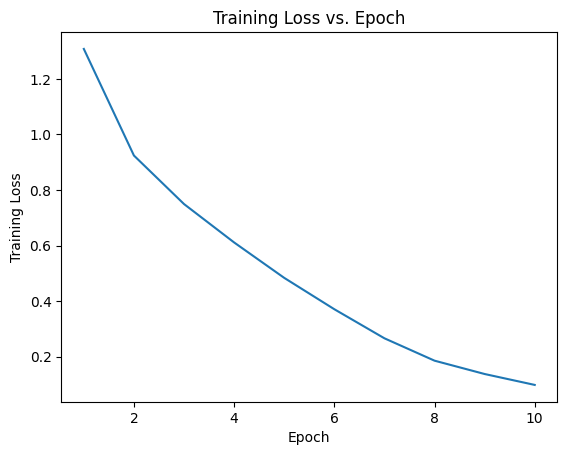

In [50]:
# Initialize list for plotting training loss
train_loss_list = []

# Training
num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(trainloader)
    train_loss_list.append(train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss}")

# Plotting Training Loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

In [51]:
# Testing
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 72.22%


In [52]:
def imshow(img):  # 画像の表示関数
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [53]:
# テストデータの読み込み
def get_test():
    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4, num_workers=16, shuffle=True)

    images, labels = next(iter(testloader))
    return images, labels

In [57]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_test_label_with_prob(images):
    with torch.no_grad():
        images = images.to(device)
        outputs = nn.functional.softmax(net(images), dim=1)  # dim=1 ensures softmax is applied to each sample
        _, predicted_indices = torch.max(outputs, 1)
        predicted_labels = [classes[idx] for idx in predicted_indices]
        predicted_probs = outputs.cpu().numpy()  # Convert the tensor to a numpy array
    return predicted_labels, predicted_probs

Files already downloaded and verified


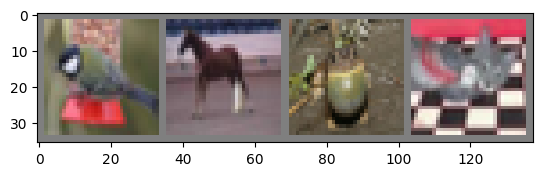

frog horse frog cat


In [60]:
images, labels = get_test()
predicted_labels, predicted_probs = get_test_label_with_prob(images)

# 画像の表示
imshow(torchvision.utils.make_grid(images))
print(*predicted_labels)

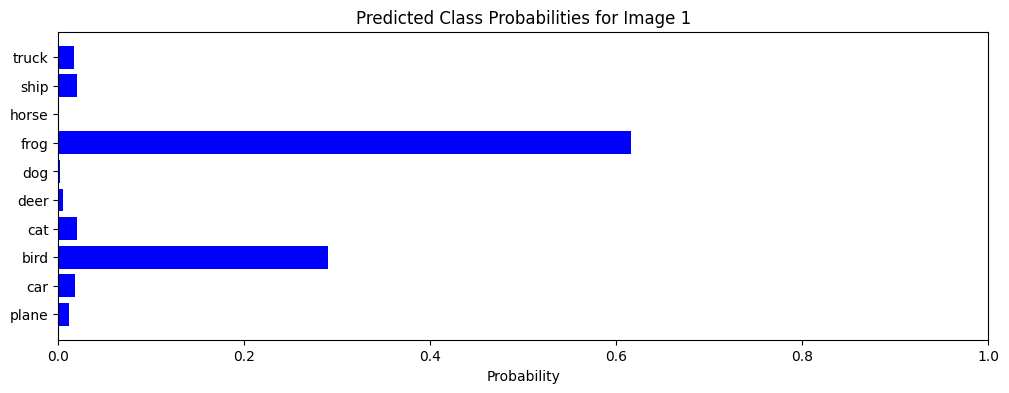

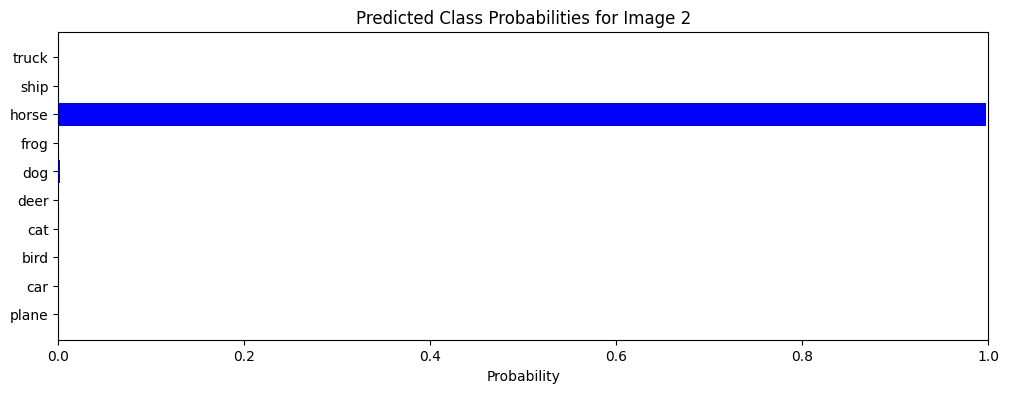

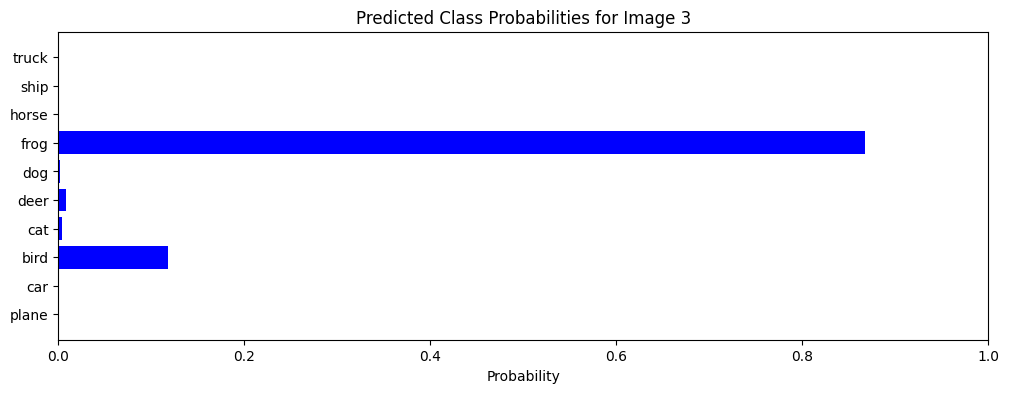

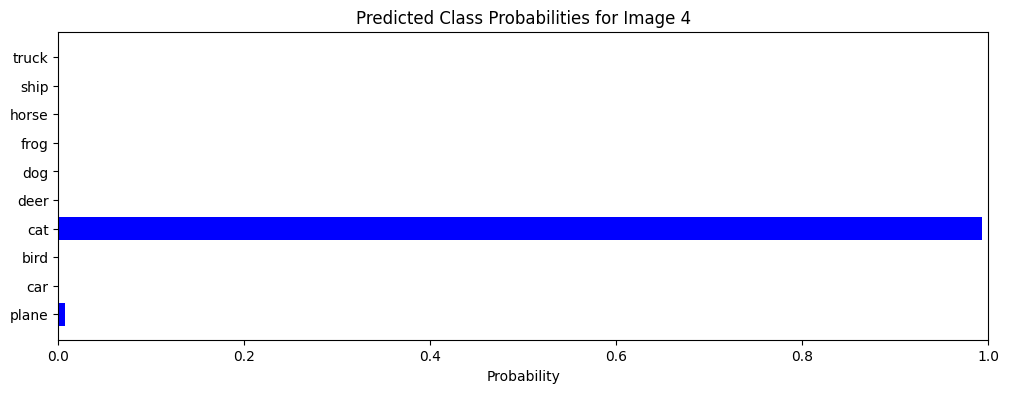

In [61]:
# 画像数
num_images = predicted_probs.shape[0]

# 各画像に対する確率をプロット
for i in range(num_images):
    plt.figure(figsize=(12, 4))
    plt.barh(classes, predicted_probs[i], color='blue')
    plt.xlabel('Probability')
    plt.title(f'Predicted Class Probabilities for Image {i+1}')
    plt.xlim(0, 1)
    plt.show()